In [128]:
import numpy as np
import random

import os
import pickle
import sys
import timeit

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_spd_matrix
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter

from matplotlib.pyplot import imshow
%matplotlib inline 

from IPython.display import Image 

import pickle

<img src="split_treatment.png" width="400"/>

Text(0.5, 1.0, 'Ground truth ITE')

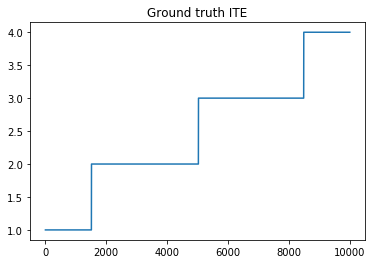

In [222]:
xDim = 50
nSim = 10000

#** Follow the graph to generate Y
# Y = X * beta + Z * CATE

#** Add a U to X, A and Y
# confounders
x_Sigma = make_spd_matrix(xDim)
X = np.random.multivariate_normal(np.zeros(xDim),x_Sigma,size=nSim)
beta = np.random.choice(5, xDim, replace=True, p =[.3, .25, .2, .15, .1])

# ground truth CATE
CATE = np.array([1,2,3,4])
p_G = np.exp(X[:,1])/(1+np.exp(X[:,1]))
Group = np.zeros(nSim)
Group[p_G < 0.75] = 1
Group[p_G < 0.5] = 2
Group[p_G < 0.25] = 3
Group = Group.astype(int)

# ground truth two-arm potential outcomes
Y_0 = np.random.normal(np.sum(X * beta,1),1)
#Y_1 = Y_0 + np.random.normal(CATE[Group],1)
Y_1 = Y_0 + CATE[Group]

# Z encourage A, and split-treatment criterion p_A_given_Z > p_A_given_notZ
p_A_given_Z = [0.8 if x[0] > 0 else 0.7 for x in X]
p_A_given_notZ = [0.5 for x in X]

# ground truth ITE plot
ite_order = np.argsort(Y_1 - Y_0)
plt.plot((Y_1 - Y_0)[ite_order])
plt.title('Ground truth ITE')

In [223]:
# generate randomized data (Z, A, X, Y)

# randomized treatment
Z = np.random.choice(2, nSim)

A = [np.random.choice(2, 1, p = [1-p_A_given_Z[i], p_A_given_Z[i]]) 
     if Z[i] == 1 else np.random.choice(2, 1, p = [1-p_A_given_notZ[i], p_A_given_notZ[i]])
    for i in range(nSim)]

Y = [Y_0[i] if Z[i] == 0 else Y_1[i] for i in range(nSim)]

Z = np.array(Z).ravel()
A = np.array(A).ravel()
Y = np.array(Y).ravel()

In [259]:
# get biased observed data 
obs_indices = [True if X[i,0] * X[i,2] > 0 else False for i in range(nSim)]

X_obs = X[obs_indices]
A_obs = A[obs_indices]
Y_obs = Y[obs_indices]

# ground truth params
Group_obs = Group[obs_indices]
Y_0_obs = Y_0[obs_indices]
Y_1_obs = Y_1[obs_indices]

nObs = sum(obs_indices)
print('Num obs:', nObs)

Num obs: 6619


In [249]:
# Fit IPTW to observed biased data (A, X, Y)
# 1. Fit propensity
clf = LogisticRegression(random_state=0).fit(X_obs, A_obs)
propensity = clf.predict_proba(X_obs)[:,1]
p_A = np.sum(A_obs)/len(A_obs)
iptw = [p_A/propensity[i] if A_obs[i] == 1 else (1-p_A)/(1-propensity[i]) for i in range(nObs)]

print('p_A: {}, IPTW: {:.2f} +/- {:.2f}'.format(p_A, np.mean(iptw), np.std(iptw)))

p_A: 0.618220274966007, IPTW: 1.00 +/- 0.12


In [270]:
# 2. Fit IPTW-LR
#model = RandomForestRegressor(max_depth=2, random_state=0).fit(np.concatenate((X,A.reshape(-1,1)),1),Y,sample_weight=iptw)
model = LinearRegression(fit_intercept=False).fit(np.concatenate((X_obs,A_obs.reshape(-1,1)),1),Y_obs,sample_weight=iptw)
Ytmp_0 = model.predict(np.concatenate((X_obs,np.zeros((nObs,1))),1))
Ytmp_1 = model.predict(np.concatenate((X_obs,np.ones((nObs,1))),1))
Yhat_0 = np.array([Y_obs[i] if A_obs[i] == 0 else Ytmp_0[i] for i in range(nObs)])
Yhat_1 = np.array([Y_obs[i] if A_obs[i] == 1 else Ytmp_1[i] for i in range(nObs)])

print('Unbiased est. CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean((Yhat_1 - Yhat_0)[Group_obs == 0]),
           np.mean((Yhat_1 - Yhat_0)[Group_obs == 1]),
                  np.mean((Yhat_1 - Yhat_0)[Group_obs == 2]),
                         np.mean((Yhat_1 - Yhat_0)[Group_obs == 3])))

indices_sort = np.argsort(Yhat_1 - Yhat_0)
recover_CATE = (Y_1_obs - Y_0_obs)[indices_sort]
print('Unbiased rec. CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(recover_CATE[:sum(Group_obs == 0)]), np.mean(recover_CATE[sum(Group_obs == 0):sum( Group_obs <= 1)]),
    np.mean(recover_CATE[sum( Group_obs <= 1):sum( Group_obs <= 2)]), np.mean(recover_CATE[sum( Group_obs <= 2):])))
print('Ground truth CATE:', CATE)

Unbiased est. CATE: 0.87, 1.02, 1.31, 1.53
Unbiased rec. CATE: 2.69, 2.19, 2.46, 3.02
Ground truth CATE: [1 2 3 4]


In [271]:
# Fit LR
model = LinearRegression(fit_intercept=False).fit(np.concatenate((X_obs,A_obs.reshape(-1,1)),1),Y_obs)
Ytmp_0 = model.predict(np.concatenate((X_obs,np.zeros((nObs,1))),1))
Ytmp_1 = model.predict(np.concatenate((X_obs,np.ones((nObs,1))),1))
Yhat_0 = np.array([Y_obs[i] if A_obs[i] == 0 else Ytmp_0[i] for i in range(nObs)])
Yhat_1 = np.array([Y_obs[i] if A_obs[i] == 1 else Ytmp_1[i] for i in range(nObs)])

print('Biased est. CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean((Yhat_1 - Yhat_0)[Group_obs == 0]),
           np.mean((Yhat_1 - Yhat_0)[Group_obs == 1]),
                  np.mean((Yhat_1 - Yhat_0)[Group_obs == 2]),
                         np.mean((Yhat_1 - Yhat_0)[Group_obs == 3])))

indices_sort = np.argsort(Yhat_1 - Yhat_0)
recover_CATE = (Y_1_obs - Y_0_obs)[indices_sort]
print('Biased rec. CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(recover_CATE[:sum(Group_obs == 0)]), np.mean(recover_CATE[sum(Group_obs == 0):sum( Group_obs <= 1)]),
    np.mean(recover_CATE[sum( Group_obs <= 1):sum( Group_obs <= 2)]), np.mean(recover_CATE[sum( Group_obs <= 2):])))
print('Ground truth CATE:', CATE)

Biased est. CATE: 0.88, 1.03, 1.32, 1.55
Biased rec. CATE: 2.68, 2.19, 2.46, 3.03
Ground truth CATE: [1 2 3 4]
